In [ ]:
# For encoding categorical data
!pip install category_encoders==2.*
from category_encoders import OneHotEncoder
# model building
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import sys

     |████████████████████████████████| 81kB 3.4MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from category_encoders import OneHotEncoder

# NYC Rent

**GOAL:** Improve our model for predicting NYC rent prices.

**Objectives**

- Do one-hot encoding of categorical features
- Do univariate feature selection
- Use scikit-learn to fit Ridge Regression models

In [ ]:
%%capture
# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

    

# I. Wrangle Data

Create **wrangle function** for **reproducibility**.

In [ ]:

def wrangle(filepath):
  df = pd.read_csv(filepath,
                   parse_dates=['created'],
                   index_col='created')
  df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

  cutoff = 5
  drop_cols = [col for col in df.select_dtypes('object') if df[col].nunique() > cutoff]    
  df.drop(columns=drop_cols,inplace=True)   
  return df      
        
df = wrangle(DATA_PATH+'apartments/renthop-nyc.csv')

In [ ]:
df.select_dtypes('object').nunique()
drop_cols =[]
cutoff = 5
for col in df.select_dtypes('object'):
  if df[col].nunique() > cutoff:
    drop_cols.append(col)
print(drop_cols)    

[]


In [ ]:
drop_cols = [col for col in df.select_dtypes('object') if df[col].nunique() > cutoff] 
drop_cols

[]

# II. Split Data

Split **target vector** from **feature matrix**.

In [ ]:
target = 'price'
y = df[target]
X = df.drop(columns=target)

Split data into **training** and **test** sets.

(Use data from April & May 2016 to train. Use data from June 2016 to test.)

In [ ]:
cutoff = '2016-06-01'
mask = X.index < cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

# III. Establish Baseline

**Note:** This is a **regression** problem because we're predictiong the continuous value `'price'`.

In [ ]:
y_pred = [y_train.mean()] * len(y_train)
print('Mean price:', y_train.mean())
print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

Mean price: 3575.604007034292
Baseline MAE: 1201.8811133682555


# IV. Build Models

**Question:** How can we represent *categorical* features numerically so that we can use them to train our model?

In [ ]:
# step 1: import your transformer class
#we did above

#step 2: instantiate your transformer
ohe = OneHotEncoder(use_cat_names = True)

#step 3: you fit your transformer to the TRAINING data
ohe.fit(X_train) #only on feature matrix (sometimes)
                 # Never refit your transformer on your TEST data

#step 4: transform my training data
XT_train = ohe.transform(X_train)
XT_test = ohe.transform(X_test)


#Regular linearl Regrassion
model_lr = LinearRegression()

model_lr.fit(XT_train,y_train)

# Ridge Regression(regularization)

model_r = Ridge(alpha = 1.0) #alpha is a hyper parameter
model_r.fit(XT_train, y_train)

#SelectKBest model

skb = SelectKBest(k=10)
skb.fit(XT_train,y_train)

XTT_train = skb.transform(XT_train)
XTT_test = skb.transform(XT_test)

model_lr2 = LinearRegression()
model_lr2.fit(XTT_train,y_train)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# V. Check Metrics

In [ ]:
print('LR training MAE:', mean_absolute_error(y_train, model_lr.predict(XT_train)))
print('LR test MAE:', mean_absolute_error(y_test, model_lr.predict(XT_test)))

LR training MAE: 673.1551409557138
LR test MAE: 676.1110962539769


In [ ]:
print('Ridge training MAE:', mean_absolute_error(y_train, model_r.predict(XT_train)))
print('Ridge test MAE:', mean_absolute_error(y_test, model_r.predict(XT_test)))

Ridge training MAE: 672.6640726589972
Ridge test MAE: 675.514908956413


In [ ]:
print('Ridge training MAE:', mean_absolute_error(y_train, model_lr2.predict(XTT_train)))
print('Ridge test MAE:', mean_absolute_error(y_test, model_lr2.predict(XTT_test)))

Ridge training MAE: 702.8736659951701
Ridge test MAE: 712.1750705952646


# Communicate results

In [ ]:
feature_names = ohe.get_feature_names()
coefficients = model_lr.coef_
feature_importances = pd.Series(coefficients,index=feature_names).sort_values(key=abs)

In [ ]:
feature_importances

cats_allowed            -3.432675e+01
garden_patio            -4.263046e+01
balcony                 -4.465050e+01
swimming_pool            5.671776e+01
dishwasher               5.679622e+01
dogs_allowed             7.594788e+01
outdoor_space           -7.846545e+01
pre-war                 -9.009727e+01
no_fee                  -1.004812e+02
laundry_in_building     -1.065068e+02
fitness_center           1.135758e+02
new_construction        -1.319848e+02
loft                     1.361026e+02
hardwood_floors         -1.417584e+02
exclusive                1.421882e+02
elevator                 1.461599e+02
common_outdoor_space    -1.525611e+02
roof_deck               -1.626352e+02
wheelchair_access        1.755704e+02
terrace                  1.783703e+02
dining_room              2.593674e+02
high_speed_internet     -2.934042e+02
doorman                  4.262460e+02
laundry_in_unit          4.764909e+02
bedrooms                 4.917048e+02
latitude                 1.233050e+03
bathrooms   

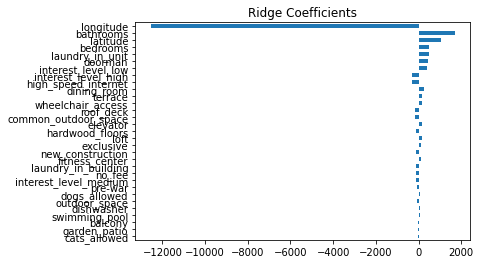

In [ ]:
feature_names = ohe.get_feature_names()
coefficients = model_r.coef_
feature_importances = pd.Series(coefficients,index=feature_names).sort_values(key=abs)
feature_importances.plot(kind='barh',title='Ridge Coefficients')